# Birdcall Recognition EDA

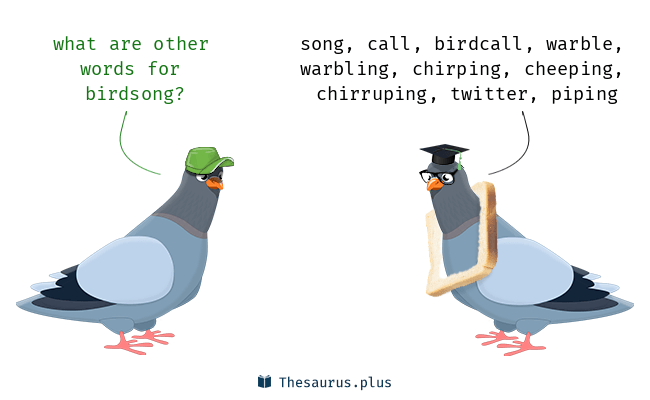

<font size='5' color='#1C2833'>Contents</font> 
<font size='3' color='#717D7E'>
1. [Loading Data and Libraries](#1)
2. [Data Exploration](#2)<br>
    2.1 [Birds and its Evnironment](#2.1)<br>
    2.2 [Audio and background](#2.2)<br>
    2.3 [Authors](#2.3)<br>
    2.4 [Locations](#2.4)<br>
    2.5 [Date wise](#2.5)<br>
    2.6 [Box plots](#2.6)<br>
3. [Audio Exploration](#3)<br>
    3.1 [Tempo](#3.1)<br>
    3.2 [Spectrogram](#3.2)<br>
    3.3 [Chromagram](#3.3)<br>
    3.4 [Tempogram](#3.4)<br>
    3.5 [Linear power spectrogram (grayscale)](#3.5)<br>
4. [Bird's song Comparison](#4)<br>
    4.1 [Amplitude](#4.1)<br>
    4.2 [Linear-frequency power spectrogram](#4.2)<br>
    4.3 [Choromagram](#4.3)<br>
    4.4 [Tempogram](#4.4)<br>
    4.5 [Linear power spectrogram (grayscale)](#4.5)<br>
    4.6 [Harmonic + Percussive](#4.6)<br>
    
   

## 1. Loading Data and Libraries<a id="1"></a> 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
""# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Input files

/kaggle/input/birdsong-recognition/test.csv

/kaggle/input/birdsong-recognition/train.csv

/kaggle/input/birdsong-recognition/example_test_audio_summary.csv

/kaggle/input/birdsong-recognition/example_test_audio_metadata.csv

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import folium
import librosa
import matplotlib.pyplot as plt
import librosa.display
from matplotlib import gridspec
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [ ]:
pd.set_option("max.columns",100)
pd.set_option("max.rows",1000)

In [ ]:
train_data = pd.read_csv("/kaggle/input/birdsong-recognition/train.csv")
print(train_data.info())
test_data = pd.read_csv('/kaggle/input/birdsong-recognition/test.csv')
print(test_data.info())

In [ ]:
test_data.head()

In [ ]:
train_data.head()

## 2. Data Exploration <a id="2"></a>

## 2.1 Birds and its environment <a id="2.1"></a>

In [ ]:
min_play = train_data.groupby(['species'])['xc_id'].count().reset_index()
min_play = min_play.rename(columns={'xc_id':'count'})
min_play.sort_values(by = ['count'], inplace = True, ascending = True)
min_play

fig = px.bar(min_play, x='count', y='species',
             hover_data=['species'], color='species',
             labels={'count':'Count'}, height=1400, width = 1000)
fig.update_layout(
    title="Species Names and Distribution - Total # Species:  264",
    xaxis_title="Counts",
    yaxis_title="Names",
    font=dict(
        family="sans serif",
        size=10,
        color="#7f7f72"
    )
)
fig.show()

In [ ]:
train_data['elevation'] = train_data['elevation'].str.replace('m','')
train_data['elevation'] = train_data['elevation'].str.replace('?','')
train_data['elevation'] = train_data['elevation'].str.replace('930-990','990')
train_data['elevation'] = train_data['elevation'].str.replace('1650-1900','1900')
train_data['elevation'] = train_data['elevation'].str.replace(',','')
train_data['elevation'] = train_data['elevation'].str.replace('Unknown','')
train_data['elevation'] = train_data['elevation'].str.replace('~','')
train_data['elevation'] = train_data['elevation'].str.replace('-','')
train_data['elevation'] = train_data['elevation'].str.replace(' ','')
train_data['elevation'] = pd.to_numeric(train_data['elevation'])

elev = train_data.groupby('elevation')['xc_id'].count().reset_index()
elev = elev.rename(columns = {'xc_id':'count'})
fig = px.scatter(elev, x='elevation', y='count', color = 'elevation')
fig.update_layout(
    title="Elevation Distribution",
    xaxis_title="Elevation",
    yaxis_title="Count",
    font=dict(
        family="sans serif",
        size=14,
        color="#7f7f72"
    )
)

In [ ]:
eled = train_data.groupby('elevation')['bird_seen'].value_counts().reset_index(name = 'counts')
p_ele = eled.pivot(columns = 'bird_seen', values = 'counts', index = 'elevation')
p_ele = p_ele.reset_index()
p_ele = p_ele.fillna(0)

fig = px.scatter(p_ele, x="yes", y="no",size="elevation", color="elevation",size_max=20, height = 600, width= 800)
fig.update_layout(
    title="Elevation vs Bird_seen",
    xaxis_title="Bird_seen Yes",
    yaxis_title="Bird_seen No",
    font=dict(
        family="sans serif",
        size=14,
        color="#7f7f72"
    )
)

In [ ]:
elevs = train_data.groupby('country')['elevation'].mean().reset_index()
fig = px.scatter(elevs, x='country', y='elevation', color = 'country')
fig.update_layout(
    title="Elevation vs country",
    xaxis_title="Country",
    yaxis_title="Elevation",
    font=dict(
        family="sans serif",
        size=14,
        color="#7f7f72"
    )
)

## 2.2 EDA - Audio and backgrounds<a id='2.2'></a>

In [ ]:
rating_count = train_data.groupby('rating')['xc_id'].count().reset_index()
rating_count = rating_count.rename(columns = {'xc_id':'count'})
fig = px.bar(rating_count, x='rating', y='count', color = 'rating')
fig.update_layout(
    title="Rating Distribution",
    xaxis_title="Ratings",
    yaxis_title="Counts",
    font=dict(
        family="sans serif",
        size=18,
        color="#7f7f7f"
    )
)
fig.show()

### More number of sound samples are having **good** ratings

In [ ]:
palyback_count = train_data.groupby('playback_used')['xc_id'].count().reset_index()
palyback_count = palyback_count.rename(columns = {'xc_id':'count'})
fig = px.bar(palyback_count, x='playback_used', y='count', color = 'playback_used')
fig.update_layout(
    title="Sound Playback Used",
    xaxis_title="Playback Used",
    yaxis_title="Counts",
    font=dict(
        family="sans serif",
        size=18,
        color="#7f7f7f"
    )
)
fig.show()

In [ ]:
channels_count = train_data.groupby('channels')['xc_id'].count().reset_index()
channels_count = channels_count.rename(columns = {'xc_id':'count'})
channels_count.channels = channels_count.channels.str.replace('(','')
channels_count.channels = channels_count.channels.str.replace(')','')
fig = px.bar(channels_count, x='channels', y='count', color = 'channels')
fig.update_layout(
    title="Channel Types",
    xaxis_title="Types",
    yaxis_title="Counts",
    font=dict(
        family="sans serif",
        size=18,
        color="#7f7f72"
    )
)
fig.show()

In [ ]:
pitch = train_data.groupby(['pitch'])['xc_id'].count().reset_index()
pitch = pitch.rename(columns={'xc_id':'count'})
fig = go.Figure(data = [go.Pie(labels = pitch.pitch,values = pitch['count'])])
fig.update_layout(
    title="Pitch Levels",
    xaxis_title="Levels",
    yaxis_title="Counts",
    font=dict(
        family="sans serif",
        size=18,
        color="#7f7f72"
    )
)
fig.show()

In [ ]:
speed = train_data.groupby(['speed'])['xc_id'].count().reset_index()
speed = speed.rename(columns={'xc_id':'count'})
fig = go.Figure(data = [go.Pie(labels = speed['speed'],values = speed['count'])])
fig.update_layout(
    title="Play Speed",
    xaxis_title="Play Speed",
    yaxis_title="Counts",
    font=dict(
        family="sans serif",
        size=18,
        color="#7f7f72"
    )
)
fig.show()

In [ ]:
notes= train_data.groupby(['number_of_notes'])['xc_id'].count().reset_index()
notes = notes.rename(columns={'xc_id':'count'})
notes.sort_values(by = ['count'], inplace = True, ascending=False)
fig = px.bar(notes, x='number_of_notes', y='count',
             hover_data=['number_of_notes'], color='number_of_notes',
             labels={'count':'count'}, height=400)
fig.update_layout(
    title="Notes Ranges",
    xaxis_title="Notes Range",
    yaxis_title="Counts",
    font=dict(
        family="sans serif",
        size=18,
        color="#7f7f72"
    )
)
fig.show()

In [ ]:
bird_seen = train_data.groupby(['bird_seen'])['xc_id'].count().reset_index()
bird_seen = bird_seen.rename(columns={'xc_id':'count'})
fig = go.Figure(data = [go.Pie(labels = bird_seen.bird_seen,values = bird_seen['count'])])
fig.update_layout(
    title="Birds Seen by Author",
    xaxis_title="Birds Seen",
    yaxis_title="Counts",
    font=dict(
        family="sans serif",
        size=18,
        color="#7f7f72"
    )
)
fig.show()

### Most of the birds have been seen by the Author

In [ ]:
stype= train_data.groupby(['type'])['xc_id'].count().reset_index()
stype = stype.rename(columns={'xc_id':'count'})
stype.sort_values(by = ['count'], inplace = True, ascending=False)
fig = px.bar(stype[0:15], x='type', y='count',
             hover_data=['type'], color='type',
             labels={'count':'count'}, height=400)
fig.update_layout(
    title="Types of Sounds",
    xaxis_title="Sound types",
    yaxis_title="Counts",
    font=dict(
        family="sans serif",
        size=18,
        color="#7f7f72"
    )
)
fig.show()

### mostly these birds sounds are songs or calls

In [ ]:
volume= train_data.groupby(['volume'])['xc_id'].count().reset_index()
volume = volume.rename(columns={'xc_id':'count'})
volume.sort_values(by = ['count'], inplace = True, ascending=False)
fig = px.bar(volume, x='count', y='volume',
             hover_data=['volume'], color='volume',
             labels={'count':'count'}, height=400)
fig.update_layout(
    title="Volume Levels",
    xaxis_title="Count",
    yaxis_title="Volume levels",
    font=dict(
        family="sans serif",
        size=18,
        color="#7f7f72"
    )
)
fig.show()

In [ ]:
slength= train_data.groupby(['length'])['xc_id'].count().reset_index()
slength = slength.rename(columns={'xc_id':'count'})
slength.sort_values(by = ['count'], inplace = True, ascending=False)
fig = px.bar(slength, x='length', y='count',
             hover_data=['length'], color='length',
             labels={'count':'count'}, height=400)
fig.update_layout(
    title="Sounds Length",
    xaxis_title="Length Category",
    yaxis_title="Count",
    font=dict(
        family="sans serif",
        size=14,
        color="#7f7f72"
    )
)
fig.show()

In [ ]:
sample_rate = train_data.groupby(['sampling_rate'])['sampling_rate'].count().reset_index(name = 'count')
fig = px.bar(sample_rate, x='sampling_rate', y='count',
             hover_data=['sampling_rate'], color='sampling_rate',
             labels={'count':'count'}, height=400)
fig.update_layout(
    title="Audio Sample Rate",
    xaxis_title="Sample Rate",
    yaxis_title="Count",
    font=dict(
        family="sans serif",
        size=14,
        color="#7f7f72"
    )
)
fig.show()

In [ ]:
country= train_data.groupby('country')['xc_id'].count().reset_index()
country = country.rename(columns={'xc_id':'count'})
fig = px.scatter(country, x="count", y="count",size="count", color="country", hover_name="country", log_x=True, size_max=60)
fig.update_layout(
    title="Country wise recordings",
    xaxis_title="Count",
    yaxis_title="Count",
    font=dict(
        family="sans serif",
        size=14,
        color="#7f7f72"
    )
)
fig.show()

### Higher number of birds sounds recored in USA followed by Canada and Mexico

## 2.3 EDA - Authors<a id='2.3'></a>

In [ ]:
author= train_data.groupby(['author','ebird_code'])['ebird_code'].count().reset_index(name = 'count')
author.sort_values(by = ['count'], inplace = True, ascending=False)
fig = px.bar(author[0:100], x='author', y='count',
             hover_data=['author'], color='ebird_code',
             labels={'count':'count'}, height=400)
fig.update_layout(
    title="Author's Works on each species",
    xaxis_title="Authors",
    yaxis_title="Count",
    font=dict(
        family="sans serif",
        size=14,
        color="#7f7f72"
    )
)

In [ ]:
author= train_data.groupby(['author'])['xc_id'].count().reset_index()
author = author.rename(columns={'xc_id':'count'})
author.sort_values(by = ['count'], inplace = True, ascending=False)
fig = px.bar(author[0:10], x='author', y='count',
             hover_data=['author'], color='author',
             labels={'count':'count'}, height=400)
fig.update_layout(
    title="Author's Works",
    xaxis_title="Authors",
    yaxis_title="Count",
    font=dict(
        family="sans serif",
        size=14,
        color="#7f7f72"
    )
)
fig.show()

In [ ]:
author_rating = train_data.groupby(['author','rating']).agg({'rating':'count'})
author_rating.columns = ["_".join(x) for x in author_rating.columns.ravel()]
author_rating = author_rating.rename(columns= {'r_a_t_i_n_g':'count'}).reset_index()
author_rating.author = author_rating.author.str.slice(0,20)

fig = px.scatter(author_rating, x="count", y="rating",size="count", color="author",size_max=50, height = 600, width= 800)
fig.update_layout(
    title="Author vs Ratings",
    xaxis_title="Count",
    yaxis_title="Ratings",
    font=dict(
        family="sans serif",
        size=14,
        color="#7f7f72"
    )
)
fig.show()

## 2.4 EDA - Location wise<a id='2.4'></a>

In [ ]:
map_data = train_data[train_data.latitude!='Not specified']
map_data.latitude = pd.to_numeric(map_data.latitude)
map_data.longitude = pd.to_numeric(map_data.longitude)

In [ ]:
map_osm = folium.Map(location=[40.742, -73.956], zoom_start=11, tiles='Stamen Terrain')

map_data.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]], 
                                              radius=10, fill_color = row['rating'])
                                             .add_to(map_osm), axis=1)

map_osm

Most of the birds are found in urban areas

In [ ]:
seen = {'yes':'green','no':'red'}
map_seen = folium.Map(location=[40.742, -73.956], zoom_start=5)

map_clr_data = map_data.dropna()

map_clr_data.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]], 
                                              radius=10, fill_color = seen[row['bird_seen']])
                                             .add_to(map_seen), axis=1)

map_seen

In [ ]:
map_data.columns

In [ ]:
map_osm = folium.Map(location=[40.742, -73.956],zoom_start=4)

map_data.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]], 
                                              radius=10, fill_color = row['elevation'])
                                             .add_to(map_osm), axis=1)

map_osm

In [ ]:
seen = train_data.groupby('country')['author'].count().reset_index()
fig = px.scatter(seen, x='country', y='author', color = 'country')
fig.update_layout(
    title="Author vs country",
    xaxis_title="Country",
    yaxis_title="Author",
    font=dict(
        family="sans serif",
        size=14,
        color="#7f7f72"
    )
)

## 2.5 EDA - Date wise <a id='2.5'></a>

In [ ]:
train_data['date'] = train_data['date'].str.replace('-00','-01')
train_data['date'] = train_data['date'].str.replace('0-01-01','2000-01-01')
train_data['date'] = train_data['date'].str.replace('1012','2012')
train_data['date'] = train_data['date'].str.replace('201-','2010')
train_data['date'] = train_data['date'].str.replace('0201007-11','2010-07-11')
train_data['date'] = train_data['date'].astype('datetime64[ns]')

In [ ]:
tdate= train_data.groupby(['date'])['xc_id'].count().reset_index(name = 'count')
fig = px.line(tdate, x='date', y='count')
fig.update_layout(
    title="Recordings by Date",
    xaxis_title="Date",
    yaxis_title="Counts",
    font=dict(
        family="sans serif",
        size=14,
        color="#7f7f72"
    )
)

In [ ]:
tdate= train_data.groupby(['date','ebird_code'])['ebird_code'].count().reset_index(name = 'count')
fig = px.scatter(tdate, x='date', y='count', color = 'ebird_code', size='count')
fig.update_layout(
    title="Birds obsorbed by date",
    xaxis_title="Date",
    yaxis_title="Counts",
    font=dict(
        family="sans serif",
        size=14,
        color="#7f7f72"
    )
)

In [ ]:
tdate= train_data.groupby(['date','bird_seen'])['bird_seen'].count().reset_index(name = 'count')
fig = px.scatter(tdate, x='date', y='count', color = 'bird_seen', size='count')
fig.update_layout(
    title="Birds seen by date",
    xaxis_title="Date",
    yaxis_title="Counts",
    font=dict(
        family="sans serif",
        size=14,
        color="#7f7f72"
    )
)

## 2.6 EDA- Box plots<a id='2.6'>

In [ ]:
fig = px.box(train_data, y="rating")
fig.show()

In [ ]:
fig = px.box(train_data, y="duration")
fig.show()

In [ ]:
fig = px.box(train_data, y="elevation")
fig.show()

In [ ]:
train_data.columns

## 3. Audio Analysis 🎼<a id='3'></a>

## 3.1 Tempo<a id ='3.1'>

In [ ]:
y, sr = librosa.load("/kaggle/input/birdsong-recognition/train_audio/houspa/XC479586.mp3")
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.title('Monophonic')

y_harm, y_perc = librosa.effects.hpss(y)
plt.subplot(2, 1, 2)
librosa.display.waveplot(y_harm, sr=sr, alpha=0.25)
librosa.display.waveplot(y_perc, sr=sr, color='r', alpha=0.5)
plt.title('Harmonic + Percussive')
plt.tight_layout()
plt.show()


In [ ]:
y1, sr1 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/dowwoo/XC460991.mp3")
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
librosa.display.waveplot(y1, sr=sr1)
plt.title('Monophonic')

y_harm, y_perc = librosa.effects.hpss(y1)
plt.subplot(2, 1, 2)
librosa.display.waveplot(y_harm, sr=sr1, alpha=0.25)
librosa.display.waveplot(y_perc, sr=sr1, color='r', alpha=0.5)
plt.title('Harmonic + Percussive')
#plt.tight_layout()
plt.show()

In [ ]:
y2, sr2 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/logshr/XC236573.mp3")
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
librosa.display.waveplot(y2, sr=sr2)
plt.title('Monophonic')

y_harm, y_perc = librosa.effects.hpss(y2)
plt.subplot(2, 1, 2)
librosa.display.waveplot(y_harm, sr=sr2, alpha=0.25)
librosa.display.waveplot(y_perc, sr=sr2, color='r', alpha=0.5)
plt.title('Harmonic + Percussive')
plt.tight_layout()
plt.show()

## 3.2 Spectrogram<a id = '3.2'>

In [ ]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(35, 15))
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [ ]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y1)), ref=np.max)
plt.figure(figsize=(35, 15))
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [ ]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y2)), ref=np.max)
plt.figure(figsize=(35, 15))
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

## 3.3 Chromagram<a id ='3.3'>

In [ ]:
C = librosa.feature.chroma_cqt(y=y, sr=sr)
plt.figure(figsize=(35, 15))
tempo, beat_f = librosa.beat.beat_track(y=y, sr=sr, trim=False)
beat_f = librosa.util.fix_frames(beat_f, x_max=C.shape[1])
Csync = librosa.util.sync(C, beat_f, aggregate=np.median)
beat_t = librosa.frames_to_time(beat_f, sr=sr)
ax1 = plt.subplot(2,1,1)
librosa.display.specshow(C, y_axis='chroma', x_axis='time')
plt.title('Chroma (linear time)')
ax2 = plt.subplot(2,1,2, sharex=ax1)
librosa.display.specshow(Csync, y_axis='chroma', x_axis='time',x_coords=beat_t)
plt.title('Chroma (beat time)')
plt.tight_layout()
plt.show()

In [ ]:
C = librosa.feature.chroma_cqt(y=y1, sr=sr1)
plt.figure(figsize=(35, 15))
tempo, beat_f = librosa.beat.beat_track(y=y1, sr=sr, trim=False)
beat_f = librosa.util.fix_frames(beat_f, x_max=C.shape[1])
Csync = librosa.util.sync(C, beat_f, aggregate=np.median)
beat_t = librosa.frames_to_time(beat_f, sr=sr)
ax1 = plt.subplot(2,1,1)
librosa.display.specshow(C, y_axis='chroma', x_axis='time')
plt.title('Chroma (linear time)')
ax2 = plt.subplot(2,1,2, sharex=ax1)
librosa.display.specshow(Csync, y_axis='chroma', x_axis='time',x_coords=beat_t)
plt.title('Chroma (beat time)')
plt.tight_layout()
plt.show()

In [ ]:
C = librosa.feature.chroma_cqt(y=y2, sr=sr2)
plt.figure(figsize=(35, 15))
tempo, beat_f = librosa.beat.beat_track(y=y2, sr=sr, trim=False)
beat_f = librosa.util.fix_frames(beat_f, x_max=C.shape[1])
Csync = librosa.util.sync(C, beat_f, aggregate=np.median)
beat_t = librosa.frames_to_time(beat_f, sr=sr)
ax1 = plt.subplot(2,1,1)
librosa.display.specshow(C, y_axis='chroma', x_axis='time')
plt.title('Chroma (linear time)')
ax2 = plt.subplot(2,1,2, sharex=ax1)
librosa.display.specshow(Csync, y_axis='chroma', x_axis='time',x_coords=beat_t)
plt.title('Chroma (beat time)')
plt.tight_layout()
plt.show()

## 3.4 Tempogram<a id = '3.4'>

In [ ]:
plt.figure(figsize=(15,4))
gram = librosa.feature.tempogram(y=y, sr=sr)
librosa.display.specshow(gram, x_axis='time', y_axis='tempo')
plt.colorbar()
plt.title('Tempogram')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
gram = librosa.feature.tempogram(y=y1, sr=sr1)
librosa.display.specshow(gram, x_axis='time', y_axis='tempo')
plt.colorbar()
plt.title('Tempogram')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
gram = librosa.feature.tempogram(y=y2, sr=sr2)
librosa.display.specshow(gram, x_axis='time', y_axis='tempo')
plt.colorbar()
plt.title('Tempogram')
plt.tight_layout()
plt.show()

## 3.5 Linear power spectrogram (grayscale)<a id = '3.5'>

In [ ]:
plt.figure(figsize=(15,4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, cmap='gray_r', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear power spectrogram (grayscale)')

In [ ]:
plt.figure(figsize=(15,4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y1)), ref=np.max)
librosa.display.specshow(D, cmap='gray_r', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear power spectrogram (grayscale)')

In [ ]:
plt.figure(figsize=(15,4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y2)), ref=np.max)
librosa.display.specshow(D, cmap='gray_r', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear power spectrogram (grayscale)')

## 4. Bird Song Audio Features Comparison<a id = '4'>

## 4.1 Amplitutde<a id = '4.1'>

In [ ]:
fig = plt.figure(figsize=(15, 13)) 
gs = gridspec.GridSpec(5, 2, width_ratios=[2, 6]) 
ax0 = plt.subplot(gs[0])
img = Image.open("/kaggle/input/osic-bird-image/bkbwar.jpg")
ax0.axis('off')
ax0.imshow(img)
ax1 = plt.subplot(gs[1])
y, sr = librosa.load("/kaggle/input/birdsong-recognition/train_audio/bkbwar/XC101580.mp3")
librosa.display.waveplot(y, sr)
ax1.plot()

ax2 = plt.subplot(gs[2])
img = Image.open("/kaggle/input/osic-bird-image/clanut.jpg")
ax2.axis('off')
ax2.imshow(img)
ax3 = plt.subplot(gs[3])
y1, sr1 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/clanut/XC391597.mp3")
librosa.display.waveplot(y1, sr1)
ax3.plot()
   
ax4 = plt.subplot(gs[4])
img = Image.open("/kaggle/input/osic-bird-image/whcspa.jpg")
ax4.axis('off')
ax4.imshow(img)
ax5 = plt.subplot(gs[5])
y2, sr2 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/whcspa/XC478423.mp3")
librosa.display.waveplot(y2, sr2)
ax5.plot()

ax6 = plt.subplot(gs[6])
img = Image.open("/kaggle/input/osic-bird-image/prawar.jpg")
ax6.axis('off')
ax6.imshow(img)
ax7 = plt.subplot(gs[7])
y3, sr3 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/prawar/XC444966.mp3")
librosa.display.waveplot(y3, sr3)
ax7.plot()

ax8 = plt.subplot(gs[8])
img = Image.open("/kaggle/input/osic-bird-image/rebwoo.jpg")
ax8.axis('off')
ax8.imshow(img)
ax9 = plt.subplot(gs[9])
y4, sr4 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/rebwoo/XC145839.mp3")
librosa.display.waveplot(y4, sr4)
ax9.plot()

## 4.2 Linear-frequency power spectrogram<a id = '4.2'>

In [ ]:
fig = plt.figure(figsize=(18, 18)) 
gs = gridspec.GridSpec(5, 2, width_ratios=[2, 6]) 
ax0 = plt.subplot(gs[0])
img = Image.open("/kaggle/input/osic-bird-image/bkbwar.jpg")
ax0.axis('off')
ax0.imshow(img)
ax1 = plt.subplot(gs[1])
y, sr = librosa.load("/kaggle/input/birdsong-recognition/train_audio/bkbwar/XC101580.mp3")
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
ax1.plot()

ax2 = plt.subplot(gs[2])
img = Image.open("/kaggle/input/osic-bird-image/clanut.jpg")
ax2.axis('off')
ax2.imshow(img)
ax3 = plt.subplot(gs[3])
y1, sr1 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/clanut/XC391597.mp3")
D1 = librosa.amplitude_to_db(np.abs(librosa.stft(y1)), ref=np.max)
librosa.display.specshow(D1, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
ax3.plot()
   
ax4 = plt.subplot(gs[4])
img = Image.open("/kaggle/input/osic-bird-image/whcspa.jpg")
ax4.axis('off')
ax4.imshow(img)
ax5 = plt.subplot(gs[5])
y2, sr2 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/whcspa/XC478423.mp3")
D2 = librosa.amplitude_to_db(np.abs(librosa.stft(y2)), ref=np.max)
librosa.display.specshow(D2, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
ax5.plot()

ax6 = plt.subplot(gs[6])
img = Image.open("/kaggle/input/osic-bird-image/prawar.jpg")
ax6.axis('off')
ax6.imshow(img)
ax7 = plt.subplot(gs[7])
y3, sr3 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/prawar/XC444966.mp3")
D3 = librosa.amplitude_to_db(np.abs(librosa.stft(y3)), ref=np.max)
librosa.display.specshow(D3, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
ax7.plot()

ax8 = plt.subplot(gs[8])
img = Image.open("/kaggle/input/osic-bird-image/rebwoo.jpg")
ax8.axis('off')
ax8.imshow(img)
ax9 = plt.subplot(gs[9])
y4, sr4 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/rebwoo/XC145839.mp3")
D4 = librosa.amplitude_to_db(np.abs(librosa.stft(y4)), ref=np.max)
librosa.display.specshow(D4, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
ax9.plot()

## 4.3 Chromagram <a id = '4.3'>

In [ ]:
fig = plt.figure(figsize=(18, 18)) 
gs = gridspec.GridSpec(5, 2, width_ratios=[2, 6]) 
ax0 = plt.subplot(gs[0])
img = Image.open("/kaggle/input/osic-bird-image/bkbwar.jpg")
ax0.axis('off')
ax0.imshow(img)
ax1 = plt.subplot(gs[1])
y, sr = librosa.load("/kaggle/input/birdsong-recognition/train_audio/bkbwar/XC101580.mp3")
C = librosa.feature.chroma_cqt(y=y, sr=sr)
librosa.display.specshow(C, y_axis='chroma', x_axis='time')
plt.title('Chroma (beat time)')
ax1.plot()

ax2 = plt.subplot(gs[2])
img = Image.open("/kaggle/input/osic-bird-image/clanut.jpg")
ax2.axis('off')
ax2.imshow(img)
ax3 = plt.subplot(gs[3])
y1, sr1 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/clanut/XC391597.mp3")
C1 = librosa.feature.chroma_cqt(y=y1, sr=sr1)
librosa.display.specshow(C1, y_axis='chroma', x_axis='time')
ax3.plot()
   
ax4 = plt.subplot(gs[4])
img = Image.open("/kaggle/input/osic-bird-image/whcspa.jpg")
ax4.axis('off')
ax4.imshow(img)
ax5 = plt.subplot(gs[5])
y2, sr2 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/whcspa/XC478423.mp3")
C2 = librosa.feature.chroma_cqt(y=y2, sr=sr2)
librosa.display.specshow(C2, y_axis='chroma', x_axis='time')
ax5.plot()

ax6 = plt.subplot(gs[6])
img = Image.open("/kaggle/input/osic-bird-image/prawar.jpg")
ax6.axis('off')
ax6.imshow(img)
ax7 = plt.subplot(gs[7])
y3, sr3 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/prawar/XC444966.mp3")
C3 = librosa.feature.chroma_cqt(y=y3, sr=sr3)
librosa.display.specshow(C3, y_axis='chroma', x_axis='time')
ax7.plot()

ax8 = plt.subplot(gs[8])
img = Image.open("/kaggle/input/osic-bird-image/rebwoo.jpg")
ax8.axis('off')
ax8.imshow(img)
ax9 = plt.subplot(gs[9])
y4, sr4 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/rebwoo/XC145839.mp3")
C4 = librosa.feature.chroma_cqt(y=y4, sr=sr4)
librosa.display.specshow(C4, y_axis='chroma', x_axis='time')
ax9.plot()

## 4.4 Chromagram <a id = '4.4'>

In [ ]:

fig = plt.figure(figsize=(18, 18)) 
gs = gridspec.GridSpec(5, 2, width_ratios=[2, 6]) 
ax0 = plt.subplot(gs[0])
img = Image.open("/kaggle/input/osic-bird-image/bkbwar.jpg")
ax0.axis('off')
ax0.imshow(img)
ax1 = plt.subplot(gs[1])
y, sr = librosa.load("/kaggle/input/birdsong-recognition/train_audio/bkbwar/XC101580.mp3")
gram = librosa.feature.tempogram(y=y, sr=sr)
librosa.display.specshow(gram, x_axis='time', y_axis='tempo')
ax1.plot()

ax2 = plt.subplot(gs[2])
img = Image.open("/kaggle/input/osic-bird-image/clanut.jpg")
ax2.axis('off')
ax2.imshow(img)
ax3 = plt.subplot(gs[3])
y1, sr1 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/clanut/XC391597.mp3")
gram1 = librosa.feature.tempogram(y=y1, sr=sr1)
librosa.display.specshow(gram1, x_axis='time', y_axis='tempo')
ax3.plot()
   
ax4 = plt.subplot(gs[4])
img = Image.open("/kaggle/input/osic-bird-image/whcspa.jpg")
ax4.axis('off')
ax4.imshow(img)
ax5 = plt.subplot(gs[5])
y2, sr2 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/whcspa/XC478423.mp3")
gram2 = librosa.feature.tempogram(y=y2, sr=sr2)
librosa.display.specshow(gram2, x_axis='time', y_axis='tempo')
ax5.plot()

ax6 = plt.subplot(gs[6])
img = Image.open("/kaggle/input/osic-bird-image/prawar.jpg")
ax6.axis('off')
ax6.imshow(img)
ax7 = plt.subplot(gs[7])
y3, sr3 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/prawar/XC444966.mp3")
gram3 = librosa.feature.tempogram(y=y3, sr=sr3)
librosa.display.specshow(gram3, x_axis='time', y_axis='tempo')
ax7.plot()

ax8 = plt.subplot(gs[8])
img = Image.open("/kaggle/input/osic-bird-image/rebwoo.jpg")
ax8.axis('off')
ax8.imshow(img)
ax9 = plt.subplot(gs[9])
y4, sr4 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/rebwoo/XC145839.mp3")
gram4 = librosa.feature.tempogram(y=y4, sr=sr4)
librosa.display.specshow(gram4, x_axis='time', y_axis='tempo')
ax9.plot()

## 4.5 Linear power spectrogram (grayscale) <a id='4.5'>

In [ ]:

fig = plt.figure(figsize=(18, 18)) 
gs = gridspec.GridSpec(5, 2, width_ratios=[2, 6]) 
ax0 = plt.subplot(gs[0])
img = Image.open("/kaggle/input/osic-bird-image/bkbwar.jpg")
ax0.axis('off')
ax0.imshow(img)
ax1 = plt.subplot(gs[1])
y, sr = librosa.load("/kaggle/input/birdsong-recognition/train_audio/bkbwar/XC101580.mp3")
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, cmap='gray_r', y_axis='linear')
ax1.plot()

ax2 = plt.subplot(gs[2])
img = Image.open("/kaggle/input/osic-bird-image/clanut.jpg")
ax2.axis('off')
ax2.imshow(img)
ax3 = plt.subplot(gs[3])
y1, sr1 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/clanut/XC391597.mp3")
D = librosa.amplitude_to_db(np.abs(librosa.stft(y1)), ref=np.max)
librosa.display.specshow(D, cmap='gray_r', y_axis='linear')
ax3.plot()
   
ax4 = plt.subplot(gs[4])
img = Image.open("/kaggle/input/osic-bird-image/whcspa.jpg")
ax4.axis('off')
ax4.imshow(img)
ax5 = plt.subplot(gs[5])
y2, sr2 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/whcspa/XC478423.mp3")
D = librosa.amplitude_to_db(np.abs(librosa.stft(y2)), ref=np.max)
librosa.display.specshow(D, cmap='gray_r', y_axis='linear')
ax5.plot()

ax6 = plt.subplot(gs[6])
img = Image.open("/kaggle/input/osic-bird-image/prawar.jpg")
ax6.axis('off')
ax6.imshow(img)
ax7 = plt.subplot(gs[7])
y3, sr3 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/prawar/XC444966.mp3")
D = librosa.amplitude_to_db(np.abs(librosa.stft(y3)), ref=np.max)
librosa.display.specshow(D, cmap='gray_r', y_axis='linear')
ax7.plot()

ax8 = plt.subplot(gs[8])
img = Image.open("/kaggle/input/osic-bird-image/rebwoo.jpg")
ax8.axis('off')
ax8.imshow(img)
ax9 = plt.subplot(gs[9])
y4, sr4 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/rebwoo/XC145839.mp3")
D = librosa.amplitude_to_db(np.abs(librosa.stft(y4)), ref=np.max)
librosa.display.specshow(D, cmap='gray_r', y_axis='linear')
ax9.plot()

## 4.6 Harmonic + Percussive <a id ='4.6'>

In [ ]:
fig = plt.figure(figsize=(18, 18)) 
gs = gridspec.GridSpec(5, 2, width_ratios=[2, 6]) 
ax0 = plt.subplot(gs[0])
img = Image.open("/kaggle/input/osic-bird-image/bkbwar.jpg")
ax0.axis('off')
ax0.imshow(img)
ax1 = plt.subplot(gs[1])
y, sr = librosa.load("/kaggle/input/birdsong-recognition/train_audio/bkbwar/XC101580.mp3")
y_harm, y_perc = librosa.effects.hpss(y)
librosa.display.waveplot(y_harm, sr=sr, alpha=0.25)
librosa.display.waveplot(y_perc, sr=sr, color='r', alpha=0.5)
ax1.plot()

ax2 = plt.subplot(gs[2])
img = Image.open("/kaggle/input/osic-bird-image/clanut.jpg")
ax2.axis('off')
ax2.imshow(img)
ax3 = plt.subplot(gs[3])
y1, sr1 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/clanut/XC391597.mp3")
y_harm1, y_perc1 = librosa.effects.hpss(y1)
librosa.display.waveplot(y_harm1, sr=sr1, alpha=0.25)
librosa.display.waveplot(y_perc1, sr=sr1, color='r', alpha=0.5)
ax3.plot()
   
ax4 = plt.subplot(gs[4])
img = Image.open("/kaggle/input/osic-bird-image/whcspa.jpg")
ax4.axis('off')
ax4.imshow(img)
ax5 = plt.subplot(gs[5])
y2, sr2 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/whcspa/XC478423.mp3")
y_harm2, y_perc2 = librosa.effects.hpss(y2)
librosa.display.waveplot(y_harm2, sr=sr2, alpha=0.25)
librosa.display.waveplot(y_perc2, sr=sr2, color='r', alpha=0.5)
ax5.plot()

ax6 = plt.subplot(gs[6])
img = Image.open("/kaggle/input/osic-bird-image/prawar.jpg")
ax6.axis('off')
ax6.imshow(img)
ax7 = plt.subplot(gs[7])
y3, sr3 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/prawar/XC444966.mp3")
y_harm3, y_perc3 = librosa.effects.hpss(y3)
librosa.display.waveplot(y_harm3, sr=sr3, alpha=0.25)
librosa.display.waveplot(y_perc3, sr=sr3, color='r', alpha=0.5)
ax7.plot()

ax8 = plt.subplot(gs[8])
img = Image.open("/kaggle/input/osic-bird-image/rebwoo.jpg")
ax8.axis('off')
ax8.imshow(img)
ax9 = plt.subplot(gs[9])
y4, sr4 = librosa.load("/kaggle/input/birdsong-recognition/train_audio/rebwoo/XC145839.mp3")
y_harm4, y_perc4 = librosa.effects.hpss(y4)
librosa.display.waveplot(y_harm4, sr=sr4, alpha=0.25)
librosa.display.waveplot(y_perc4, sr=sr4, color='r', alpha=0.5)
ax9.plot()

## If you like this kernel plz <font color='red'>UPVOTE</font>.
## If you have suggestions to improve this kernel plz <font color='red'>COMMENT</font>.

<font color='Blue'>************************ Notebook is under construction ************************</font>